In [172]:
from commonfunctions import *
import cv2
import os
from PIL import Image
import matplotlib.pyplot as plt

In [202]:
IMAGE_DIR = 'yalefaces'
DEFAULT_SIZE = [250, 250] 

def read_images(image_path=IMAGE_DIR, default_size=DEFAULT_SIZE):
    images = []
    images_names = []
    image_names = [image for image in os.listdir(image_path) if not image.startswith('.')]
    for image_name in image_names:
        image = Image.open (os.path.join(image_path, image_name))
        image = image.convert ("L")
        # resize to given size (if given )
        if (default_size is not None ):
            image = image.resize (default_size , Image.ANTIALIAS )
        images.append(np.asarray (image , dtype =np. uint8 ))
        image_name_ = image_name.partition('.')[0]
        images_names.append(image_name_)
    #images_names = list(dict.fromkeys(images_names))
    images = np.array(images)
    print(images_names)
    return [images,images_names]

In [203]:
def as_row_matrix (X):
    if len (X) == 0:
        return np. array ([])
    mat = np. empty ((0 , X [0].size ), dtype =X [0]. dtype )
    for row in X:
        mat = np.vstack(( mat , np.asarray( row ).reshape(1 , -1))) # 1 x r*c 
    return mat

['subject01', 'subject01', 'subject01', 'subject01', 'subject01', 'subject01', 'subject01', 'subject01', 'subject01', 'subject01', 'subject02', 'subject02', 'subject02', 'subject02', 'subject02', 'subject02', 'subject02', 'subject02', 'subject02', 'subject02', 'subject03', 'subject03', 'subject03', 'subject03', 'subject03', 'subject03', 'subject03', 'subject03', 'subject03', 'subject03', 'subject04', 'subject04', 'subject04', 'subject04', 'subject04', 'subject04', 'subject04', 'subject04', 'subject04', 'subject04', 'subject05', 'subject05', 'subject05', 'subject05', 'subject05', 'subject05', 'subject05', 'subject05', 'subject05', 'subject05', 'subject06', 'subject06', 'subject06', 'subject06', 'subject06', 'subject06', 'subject06', 'subject06', 'subject06', 'subject06', 'subject07', 'subject07', 'subject07', 'subject07', 'subject07', 'subject07', 'subject07', 'subject07', 'subject07', 'subject07', 'subject08', 'subject08', 'subject08', 'subject08', 'subject08', 'subject08', 'subject08'

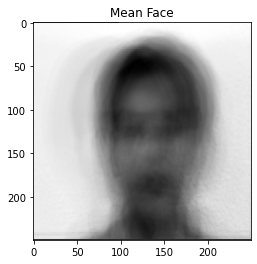

In [204]:
[X, y] = read_images()      
average_weight_matrix = np.reshape(as_row_matrix(X).mean( axis =0), X[0].shape)
plt.imshow(average_weight_matrix, cmap=plt.cm.gray)
plt.title("Mean Face")
plt.show()

In [205]:
def get_number_of_components_to_preserve_variance(eigenvalues, variance=.95):
    for ii, eigen_value_cumsum in enumerate(np.cumsum(eigenvalues) / np.sum(eigenvalues)):
        if eigen_value_cumsum > variance:
            return ii
def pca (X, y, num_components =0):
    # n : samples , d : dimension of each sample as a row
    [n,d] = X.shape    
    if ( num_components <= 0) or ( num_components >n):
        num_components = n
    mu = X.mean( axis =0)
    X = X - mu
    if n>d:
        C = np.dot(X.T,X) # Covariance Matrix
        [ eigenvalues , eigenvectors ] = np.linalg.eigh(C)
    else :
        C = np.dot (X,X.T) # Covariance Matrix
        [ eigenvalues , eigenvectors ] = np.linalg.eigh(C)
        eigenvectors = np.dot(X.T, eigenvectors )
        for i in range (n):
            eigenvectors [:,i] = eigenvectors [:,i]/ np.linalg.norm( eigenvectors [:,i])
    # sort eigenvectors descending by their eigenvalue
    idx = np.argsort (- eigenvalues )
    eigenvalues = eigenvalues [idx ]
    eigenvectors = eigenvectors [:, idx ]
    num_components = get_number_of_components_to_preserve_variance(eigenvalues)
    # select only num_components
    eigenvalues = eigenvalues [0: num_components ].copy ()
    eigenvectors = eigenvectors [: ,0: num_components ].copy ()
    return [ eigenvalues , eigenvectors , mu]  

#[eigenvalues, eigenvectors, mean] = pca (as_row_matrix(X), y)

In [206]:
[X, y] = read_images() 
X_rows = as_row_matrix(X)
[eigenvalues, eigenvectors, mu] = pca (as_row_matrix(X), y, 15)

projections = np.dot (X_rows - mu , eigenvectors)
print(P.shape)

['subject01', 'subject01', 'subject01', 'subject01', 'subject01', 'subject01', 'subject01', 'subject01', 'subject01', 'subject01', 'subject02', 'subject02', 'subject02', 'subject02', 'subject02', 'subject02', 'subject02', 'subject02', 'subject02', 'subject02', 'subject03', 'subject03', 'subject03', 'subject03', 'subject03', 'subject03', 'subject03', 'subject03', 'subject03', 'subject03', 'subject04', 'subject04', 'subject04', 'subject04', 'subject04', 'subject04', 'subject04', 'subject04', 'subject04', 'subject04', 'subject05', 'subject05', 'subject05', 'subject05', 'subject05', 'subject05', 'subject05', 'subject05', 'subject05', 'subject05', 'subject06', 'subject06', 'subject06', 'subject06', 'subject06', 'subject06', 'subject06', 'subject06', 'subject06', 'subject06', 'subject07', 'subject07', 'subject07', 'subject07', 'subject07', 'subject07', 'subject07', 'subject07', 'subject07', 'subject07', 'subject08', 'subject08', 'subject08', 'subject08', 'subject08', 'subject08', 'subject08'

In [207]:
def dist_metric(p,q):
    p = np.asarray(p).flatten()
    q = np.asarray (q).flatten()
    return np.sqrt (np.sum (np. power ((p-q) ,2)))

def predict (W, mu , projections, y, X):
    minDist = float("inf")
    minClass = -1
    Q = np.dot (X.reshape (1 , -1) - mu , eigenvectors)
    print("P",len(projections))
    for i in range (len(projections)):
        dist = dist_metric( projections[i], Q)
        if dist < minDist:
            minDist = dist
            minClass = i
    return minClass

In [208]:
def subplot ( title , images , rows , cols , sptitle ="", sptitles =[] , colormap = plt.cm.gray, filename = None, figsize = (10, 10) ):
    fig = plt.figure(figsize = figsize)
    # main title
    fig.text (.5 , .95 , title , horizontalalignment ="center")
    for i in range ( len ( images )):
        ax0 = fig.add_subplot( rows , cols ,( i +1))
        plt.setp ( ax0.get_xticklabels() , visible = False )
        plt.setp ( ax0.get_yticklabels() , visible = False )
        if len ( sptitles ) == len ( images ):
            plt.title("%s #%s" % ( sptitle , str ( sptitles [i ]) )  )
        else:
            plt.title("%s #%d" % ( sptitle , (i +1) )  )
        plt.imshow(np.asarray(images[i]) , cmap = colormap )
    if filename is None :
        plt.show()
    else:
        fig.savefig( filename )

P 150
123


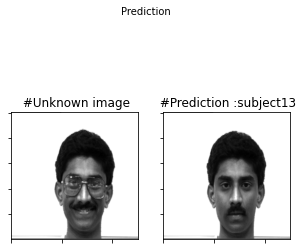

In [213]:
image = Image.open("test/subject13.happy")
image = image.convert ("L")
if (DEFAULT_SIZE is not None ):
    image = image.resize (DEFAULT_SIZE , Image.ANTIALIAS )
test_image = np. asarray (image , dtype =np. uint8 )
predicted = predict(eigenvectors, mean , projections, y, test_image)
print(predicted)
subplot ( title ="Prediction", images =[test_image, X[predicted]], rows =1, cols =2, 
         sptitles = ["Unknown image", "Prediction :{0}".format(y[predicted])] , colormap =plt.cm.gray , 
         filename ="prediction_test.png", figsize = (5,5))